# NSCM 32

Tero Frondelius, Thomas Helfer, Ivan Yashchuk, Joona Vaara, and Anssi Laukkanen

1. University of Oulu, firstname.lastname@oulu.fi
2. VTT Technical Research Centre of Finland, firstname.lastname@vtt.fi
3. Wärtsilä R&D and Engineering, firstname.lastname@wartsila.com 
4. CEA, DEN, DEC, France, thomas.helfer@cea.fr 

In [1]:
norton = raw"""
@DSL Implicit;
@Author Thomas Helfer;
@Date 3 / 08 / 2018;
@Behaviour Norton;
@Description {
  "This file implements the Norton law "
  "using the StandardElastoViscoplasticity brick"
}

@ModellingHypotheses{".+"};
@Epsilon 1.e-16;

@Brick StandardElastoViscoPlasticity{
  stress_potential : "Hooke" {young_modulus : 150e6, poisson_ratio : 0.3},
  inelastic_flow : "Norton" {criterion : "Mises", A : 8.e-67, n : 8.2, K : 1}
};
""";

In [2]:
mfront_fn = "norton.mfront"
open(mfront_fn,"w") do fil
    write(fil,norton)
end

427

In [3]:
cur_dir = pwd()
pkg_dir = dirname(Base.find_package("MFrontInterface"))
lib_dir = joinpath(pkg_dir,"..","deps","usr","lib")
home_dir = joinpath(pkg_dir,"..","deps","usr")
bin_dir = joinpath(pkg_dir,"..","deps","usr","bin")
cur_path = ENV["PATH"]

"/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin"

In [4]:
envfil = """
#!/bin/bash
export TFELHOME=$home_dir
export MGISHOME=$home_dir
export LD_LIBRARY_PATH=$lib_dir
export PATH=$bin_dir:$cur_path
mfront --install-path=$cur_dir --obuild --interface=generic $mfront_fn
patchelf --set-rpath $lib_dir src/libBehaviour.so
"""
open("build.sh","w") do fil
    write(fil,envfil)
end

639

In [5]:
chmod("build.sh",0o777)
run(`./build.sh`)

Treating target : all
The following library has been built :
- libBehaviour.so :  Norton_AxisymmetricalGeneralisedPlaneStrain Norton_AxisymmetricalGeneralisedPlaneStress Norton_Axisymmetrical Norton_PlaneStress Norton_PlaneStrain Norton_GeneralisedPlaneStrain Norton_Tridimensional


Process(`./build.sh`, ProcessExited(0))

In [6]:
using MFrontInterface, FEMMaterials, PyPlot
mgis_bv = MFrontInterface.behaviour

MFrontInterface.behaviour

In [7]:
function MFrontMaterialFunction()
    lib_path = "src/libBehaviour.so"
    behaviour_name = "Norton"
    hypothesis = mgis_bv.Tridimensional

    behaviour = load(lib_path, behaviour_name, hypothesis)
    behaviour_data = BehaviourData(behaviour)

    ext_variable_names = [mgis_bv.get_name(mgis_bv.get_external_state_variables(behaviour)[i]) for i in 1:mgis_bv.length(mgis_bv.get_external_state_variables(behaviour))]
    ext_variable_values = zeros(length(ext_variable_names))
    ext_vatiable_state = MFrontExternalVariableState(names=ext_variable_names, values=ext_variable_values)

    return MFrontMaterial(behaviour=behaviour, behaviour_data=behaviour_data, external_variables=ext_vatiable_state)
end

MFrontMaterialFunction (generic function with 1 method)

In [8]:
e11 = 0.0001*vcat(Array(range(0, stop=1.5e-2, length=30)), Array(range(1.5e-2, stop=-1.5e-2, length=30)), Array(range(-1.5e-2, stop=3e-2, length=40)))
e22 = -e11/2
e33 = e22
strains = [[e11[i], e22[i], e33[i], 0.0, 0.0, 0.0] for i in 1:100]

100-element Array{Array{Float64,1},1}:
 [0.0, -0.0, -0.0, 0.0, 0.0, 0.0]                                                      
 [5.172413793103449e-8, -2.5862068965517245e-8, -2.5862068965517245e-8, 0.0, 0.0, 0.0] 
 [1.0344827586206898e-7, -5.172413793103449e-8, -5.172413793103449e-8, 0.0, 0.0, 0.0]  
 [1.5517241379310344e-7, -7.758620689655172e-8, -7.758620689655172e-8, 0.0, 0.0, 0.0]  
 [2.0689655172413796e-7, -1.0344827586206898e-7, -1.0344827586206898e-7, 0.0, 0.0, 0.0]
 [2.5862068965517245e-7, -1.2931034482758622e-7, -1.2931034482758622e-7, 0.0, 0.0, 0.0]
 [3.103448275862069e-7, -1.5517241379310344e-7, -1.5517241379310344e-7, 0.0, 0.0, 0.0] 
 [3.6206896551724143e-7, -1.8103448275862071e-7, -1.8103448275862071e-7, 0.0, 0.0, 0.0]
 [4.137931034482759e-7, -2.0689655172413796e-7, -2.0689655172413796e-7, 0.0, 0.0, 0.0] 
 [4.655172413793103e-7, -2.3275862068965515e-7, -2.3275862068965515e-7, 0.0, 0.0, 0.0] 
 [5.172413793103449e-7, -2.5862068965517245e-7, -2.5862068965517245e-7, 0.0, 0.0,

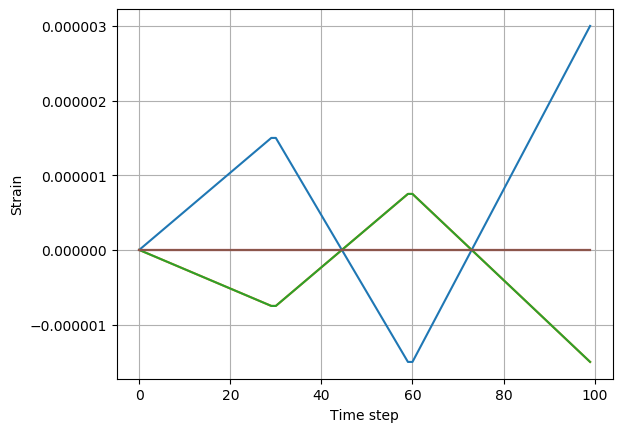

In [9]:
PyPlot.plot(strains)
PyPlot.xlabel("Time step")
PyPlot.ylabel("Strain")
PyPlot.grid()
PyPlot.show()

In [10]:
mat = MFrontMaterialFunction()
sim = Simulator(mat)
ts = 0.01:0.01:1.0
FEMMaterials.initialize!(sim, strains, ts)
FEMMaterials.run!(sim)

In [ ]:
s11 = []; str11 = []
for (stre, stra) in zip(sim.stresses,sim.strains)
    push!(s11,stre[1])
    push!(str11,stra[1])
end

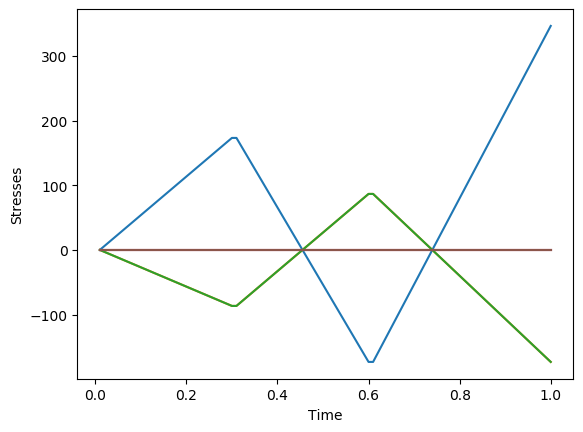

In [11]:
PyPlot.plot(ts,sim.stresses)
PyPlot.xlabel("Time")
PyPlot.ylabel("Stresses")
PyPlot.show()

In [12]:
download("https://raw.githubusercontent.com/JuliaFEM/FEMMaterials.jl/master/examples/data_3dbeam/plastic_beam.inp", "plastic_beam.inp")

"plastic_beam.inp"

In [13]:
using JuliaFEM, Materials, FEMBase;
import FEMMaterials: Continuum3D, MecaMatSo

In [14]:
mesh = abaqus_read_mesh("plastic_beam.inp");
beam_elements = create_elements(mesh, "Body1");
bc_elements_1 = create_nodal_elements(mesh, "BC1");
bc_elements_2 = create_nodal_elements(mesh, "BC2");
trac_elements = create_surface_elements(mesh, "PRESSURE");

┌ Warning: Unknown section: 'HEADING'
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:264
┌ Info: 189 nodes found
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:103
┌ Info: Parsing elements. Type: C3D8. Topology: Hex8
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:147
┌ Info: Adding elset: Body1
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:82
┌ Info: Creating nset BC1
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset BC2
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Warning: Unknown section: 'SOLID SECTION'
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:264
┌ Info: Creating nset BC1
└ @ AbaqusReader /home/tero/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset BC2
└ @ AbaqusReader /home/tero/.j

In [15]:
for j in 1:3
    update!(bc_elements_1, "displacement $j", 0.0)
end
update!(bc_elements_2, "displacement 1", 0.0)
update!(bc_elements_2, "displacement 2", 0.0)
update!(trac_elements, "surface pressure", 0.0 => 0.00)
update!(trac_elements, "surface pressure", 1.0 => 2.70e-4)
trac = Problem(Elasticity, "traction", 3)
bc = Problem(Dirichlet, "fix displacement", 3, "displacement")
add_elements!(trac, trac_elements)
add_elements!(bc, bc_elements_1)
add_elements!(bc, bc_elements_2)

┌ Info: Updating field `displacement 1` => 0.0 for 3 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:328
┌ Info: Updating field `displacement 2` => 0.0 for 3 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:328
┌ Info: Updating field `displacement 3` => 0.0 for 3 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:328
┌ Info: Updating field `displacement 1` => 0.0 for 3 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:328
┌ Info: Updating field `displacement 2` => 0.0 for 3 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:328
┌ Info: Updating field `surface pressure` for 40 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:323
┌ Info: Updating field `surface pressure` for 40 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:323
┌ Info: Creating a new problem of type Elasticity, havin

In [ ]:
# These are IdealPlastic (Materials.jl) model parameters
update!(beam_elements, "youngs_modulus", 200.0e3)
update!(beam_elements, "poissons_ratio", 0.3)
update!(beam_elements, "yield_stress", 100.0)

In [16]:
beam = Problem(Continuum3D, "plastic beam", 3)
beam.properties.material_model = :(Main.MFrontMaterialFunction) #:IdealPlastic #
add_elements!(beam, beam_elements)

┌ Info: Creating a new problem of type Continuum3D, having name `plastic beam` and dimension 3 dofs/node.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/problems.jl:136
┌ Info: Adding 80 elements to problem `plastic beam`
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/problems.jl:382


In [17]:
analysis = Analysis(MecaMatSo, "solve problem")
analysis.properties.max_iterations = 50
analysis.properties.t0 = 0.0
analysis.properties.t1 = 1.0
analysis.properties.dt = 0.05
temperature = 293.15
update!(beam_elements, "external_variables", [temperature])

┌ Info: Creating a new analysis of type MecaMatSo with name `solve problem`.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/analysis.jl:30
┌ Info: Updating field `external_variables` for 80 elements.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/elements.jl:323


In [18]:
xdmf = Xdmf("3dbeam_results_output"; overwrite=true)
add_results_writer!(analysis, xdmf)

In [19]:
add_problems!(analysis, beam, trac, bc)
run!(analysis)
close(xdmf)

┌ Info: Adding problem `plastic beam` to analysis `solve problem`.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/analysis.jl:36
┌ Info: Adding problem `traction` to analysis `solve problem`.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/analysis.jl:36
┌ Info: Adding problem `fix displacement` to analysis `solve problem`.
└ @ FEMBase /home/tero/.julia/packages/FEMBase/sO4aw/src/analysis.jl:36
┌ Info: Solving for time 0.05, iteration # 1
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:333
┌ Info: Inf
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:379
┌ Info: Solving for time 0.05, iteration # 2
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:333
┌ Info: 1.8839038450895205e-21
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:379
┌ Info: Solution converged in 2 iterations.
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mec

┌ Info: Solution converged in 2 iterations.
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:381
┌ Info: Solving for time 0.75, iteration # 1
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:333
┌ Info: Inf
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:379
┌ Info: Solving for time 0.75, iteration # 2
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:333
┌ Info: 1.8599156073254827e-21
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:379
┌ Info: Solution converged in 2 iterations.
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:381
┌ Info: Solving for time 0.8, iteration # 1
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:333
┌ Info: Inf
└ @ FEMMaterials /home/tero/.julia/packages/FEMMaterials/lDZpI/src/mecamatso.jl:379
┌ Info: Solving for time 0.8, iteration # 2
└ @ FEM

# Thank you for your attention!